## Import

In [38]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from datetime import datetime

import re

from selenium import webdriver
from selenium.webdriver.common.by import By

from chromedriver_py import binary_path
from selenium.webdriver.chrome.service import Service
from selenium import webdriver

from selenium.common.exceptions import NoSuchElementException

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import tree, ensemble
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report

In terminal:
    
pip install chromedriver-py==119.0.6045.105


In [2]:
def scraper():
    
    grounds_list = []
    surfaces_list = []
    bedrooms_list = []
    bathrooms_list = []
    EPCS_list = []
    
    ## Links
    links = driver.find_elements("xpath","//a[@class='card_card__coq1t']")
    links_list = []
    
    for link in links:
        links_list.append(str(link.text))  
    
    links_list = [link.replace('immoscoop only\nimmoscoop only:\n', '') for link in links_list]
    
    ## Prices
    prices = driver.find_elements("xpath","//p[@class='card_price__Bn4cO']")
    prices_list = []
    
    for price in prices:
        num = price.text
        num = ''.join(filter(str.isdigit, num))
        try :
            prices_list.append(int(num))
        except ValueError:
            prices_list.append('-')
        
    ## Addresses    
    addresses = driver.find_elements("xpath","//address[@class='text-sm leading-4 font-medium text-gray-500 not-italic']")
    addresses_list = []
    
    for address in addresses:
        addresses_list.append(str(address.text))    
    
    ## Surface, ground, bedroom and bathrooms
    for data in links_list:
        elements = data.split('\n')
        h = elements[-4:]
        
        if h[0].isdigit():
            surfaces_list.append(h[0])
            grounds_list.append(h[1])
            bedrooms_list.append(h[2])
            bathrooms_list.append(h[3])
        else:
            grounds_list.append(None)
            surfaces_list.append(h[1])
            bedrooms_list.append(h[2])
            bathrooms_list.append(h[3])
        
    ## EPC 
    epc_pattern = re.compile(r'EPC\n([ABC])')
    
    # Define regular expressions for nB, nA, nC values
    nb_pattern = re.compile(r'nB\n(\d+)')
    na_pattern = re.compile(r'nA\n(\d+)')
    nc_pattern = re.compile(r'nC\n(\d+)')
        
    for data in links_list:
        epc_match = epc_pattern.search(data)
        nb_match = nb_pattern.search(data)
        na_match = na_pattern.search(data)
        nc_match = nc_pattern.search(data)
    
        epc_value = epc_match.group(1) if epc_match else None
        nb_value = nb_match.group(1) if nb_match else None
        na_value = na_match.group(1) if na_match else None
        nc_value = nc_match.group(1) if nc_match else None
    
        EPCS_list.append(epc_value)
            
    ##Create DataFrame
    df = pd.DataFrame(
    {'Price': prices_list,
     'Address': addresses_list,
     'Surface': surfaces_list,
     'Ground':grounds_list,
     'Bedrooms':bedrooms_list,
     'Bathrooms': bathrooms_list,
     'EPC': EPCS_list,
     'Parking': parking_value ,
     'Balcony': balcony_value ,
    })

    return df

In [8]:
## INPUT ##
parking_value = 'Yes'
balcony_value = 'Yes'

data = []

options = webdriver.ChromeOptions()
    
driver = webdriver.Chrome(service=Service(executable_path=binary_path), options=options)

if parking_value == 'No' and balcony_value == 'No':
    driver.get("https://www.immoscoop.be/zoeken/te-koop/2000-antwerpen/alle/appartement")
elif parking_value == 'Yes' and balcony_value == 'No':    
    driver.get("https://www.immoscoop.be/zoeken/te-koop/2000-antwerpen/alle/appartement?parkingAvailable=true")
elif parking_value == 'No' and balcony_value == 'Yes':    
    driver.get("https://www.immoscoop.be/zoeken/te-koop/2000-antwerpen/alle/appartement?terrace=true")
elif parking_value == 'Yes' and balcony_value == 'Yes':    
    driver.get("https://www.immoscoop.be/zoeken/te-koop/2000-antwerpen/alle/appartement?terrace=true&parkingAvailable=true")

time.sleep(5)

## Accept cookies
cookie = driver.find_element("xpath","//button[@id='onetrust-reject-all-handler']")
cookie.click()
    
while True:
    df = scraper()   
    
    data.append(df)

    try:
        next_button = driver.find_element("xpath","//a[@aria-label='Next page']")
    except  NoSuchElementException:
        print("button not found")
        break

    #next_button = driver.find_element("xpath","//*[@id='__next']/div/div/main/div/main/div/div[4]/div[1]/div[2]/nav/ul/li[9]/a[@aria-label='Next page']")
    #//*[@id="__next"]/div/div/main/div/main/div/div[4]/div[1]/div[2]/nav/ul/li[10]/a
    #//*[@id="__next"]/div/div/main/div/main/div/div[4]/div[1]/div[2]/nav/ul/li[10]/a

    driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
    time.sleep(5)
    
    if next_button.get_attribute("aria-disabled") == "true":
        break
        
    next_button.click()
    time.sleep(5)
    
final_df = pd.concat(data, ignore_index=True)    

In [9]:
final_df.to_excel("scrape_antwerp_YY.xlsx") 

In [ ]:
result_df = pd.concat([final_df1, final_df2, final_df3, final_df5], ignore_index=True)
result_df.to_excel("scrape_antwerp_NN.xlsx") 

## Data Cleaning

In [4]:
scrape1 = pd.read_excel('scrape_antwerp_YY.xlsx')
scrape2 = pd.read_excel('scrape_antwerp_NN.xlsx')
scrape3 = pd.read_excel('scrape_antwerp_NY.xlsx')
scrape4 = pd.read_excel('scrape_antwerp_YN.xlsx')

df1 = pd.concat([scrape1, scrape2, scrape3, scrape4], ignore_index=True)

In [5]:
df1

,Unnamed: 0,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony
0,0,495000,Kipdorpvest 10\n2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes
1,1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes
2,2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes
3,3,399000,Frankrijklei 5\n2000 Antwerpen,67,67.0,1,1,A,Yes,Yes
4,4,475000,Geuzenstraat 11\n2000 Antwerpen,100,NaN,2,1,C,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...
1091,581,189500,Rodestraat 25\n2000 Antwerpen,38,NaN,1,1,C,No,No
1092,582,620000,Entrepotkaai 6\n2000 Antwerpen,120,120.0,2,1,B,No,No
1093,583,699000,Bordeauxstraat 7\n2000 Antwerpen,155,850.0,2,2,NaN,No,No
1094,584,999000,Bordeauxstraat 7\n2000 Antwerpen,238,850.0,3,2,NaN,No,No


In [6]:
df1 = df1.drop('Unnamed: 0', axis=1)
df1

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony
0,495000,Kipdorpvest 10\n2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes
3,399000,Frankrijklei 5\n2000 Antwerpen,67,67.0,1,1,A,Yes,Yes
4,475000,Geuzenstraat 11\n2000 Antwerpen,100,NaN,2,1,C,Yes,Yes
...,...,...,...,...,...,...,...,...,...
1091,189500,Rodestraat 25\n2000 Antwerpen,38,NaN,1,1,C,No,No
1092,620000,Entrepotkaai 6\n2000 Antwerpen,120,120.0,2,1,B,No,No
1093,699000,Bordeauxstraat 7\n2000 Antwerpen,155,850.0,2,2,NaN,No,No
1094,999000,Bordeauxstraat 7\n2000 Antwerpen,238,850.0,3,2,NaN,No,No


### Duplicates

In [7]:
duplicate_rows = df1[df1.duplicated()]
duplicate_rows

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony
5,475000,Geuzenstraat 11\n2000 Antwerpen,100,NaN,2,1,C,Yes,Yes
124,696600,Italiëlei 209\n2000 Antwerpen,Italiëlei 209,NaN,2000 Antwerpen,Bekijk het project,NaN,No,No
135,475000,Geuzenstraat 11\n2000 Antwerpen,100,NaN,2,1,C,No,No
152,599000,Cuylitsstraat 15\n2000 Antwerpen,103,NaN,2,1,NaN,No,No
198,165000,Braziliëstraat 24\n2000 Antwerpen,28,NaN,1,1,B,No,No
...,...,...,...,...,...,...,...,...,...
1091,189500,Rodestraat 25\n2000 Antwerpen,38,NaN,1,1,C,No,No
1092,620000,Entrepotkaai 6\n2000 Antwerpen,120,120.0,2,1,B,No,No
1093,699000,Bordeauxstraat 7\n2000 Antwerpen,155,850.0,2,2,NaN,No,No
1094,999000,Bordeauxstraat 7\n2000 Antwerpen,238,850.0,3,2,NaN,No,No


In [8]:
df_no_duplicates = df1.drop_duplicates()
df_no_duplicates

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony
0,495000,Kipdorpvest 10\n2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes
3,399000,Frankrijklei 5\n2000 Antwerpen,67,67.0,1,1,A,Yes,Yes
4,475000,Geuzenstraat 11\n2000 Antwerpen,100,NaN,2,1,C,Yes,Yes
...,...,...,...,...,...,...,...,...,...
980,199500,Borzestraat 5\n2000 Antwerpen,51,NaN,1,1,NaN,No,No
997,285000,Louizastraat 36\n2000 Antwerpen,80,NaN,2,1,C,No,No
1035,570000,Indiëstraat 49\n2000 Antwerpen,109,NaN,2,1,A,No,No
1061,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No


In [9]:
df = df_no_duplicates

### Price

In [10]:
non_integer_values = df.loc[~df['Price'].apply(lambda x: isinstance(x, int)), 'Price']
non_integer_values

20     -
190    -
233    -
346    -
415    -
430    -
453    -
507    -
570    -
634    -
643    -
679    -
Name: Price, dtype: object

### Address

Adressen zonder straat 

In [11]:
address_pattern = re.compile(r'^.+ \d{1,5}\n\d{4} .+$')

non_matching_addresses = df.loc[~df['Address'].apply(lambda x: bool(address_pattern.match(x))), 'Address']
non_matching_addresses

1       2000 Antwerpen
2       2000 Antwerpen
10      2000 Antwerpen
27      2000 Antwerpen
28      2000 Antwerpen
             ...      
683     2000 Antwerpen
687     2000 Antwerpen
693     2000 Antwerpen
1061    2000 Antwerpen
1069    2000 Antwerpen
Name: Address, Length: 189, dtype: object

Adressen zonder huisnummer

In [12]:

# Identify values that do not match the address pattern
non_matching_addresses = df.loc[
    ~df['Address'].apply(lambda x: bool(address_pattern.match(x))) &
    ~df['Address'].apply(lambda x: bool(re.match(r'^\d{4} .+$', x))),
    'Address']

non_matching_addresses

49     Ellermanstraat\n2000 Antwerpen
513    Ellermanstraat\n2000 Antwerpen
Name: Address, dtype: object

In [13]:
df

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony
0,495000,Kipdorpvest 10\n2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes
3,399000,Frankrijklei 5\n2000 Antwerpen,67,67.0,1,1,A,Yes,Yes
4,475000,Geuzenstraat 11\n2000 Antwerpen,100,NaN,2,1,C,Yes,Yes
...,...,...,...,...,...,...,...,...,...
980,199500,Borzestraat 5\n2000 Antwerpen,51,NaN,1,1,NaN,No,No
997,285000,Louizastraat 36\n2000 Antwerpen,80,NaN,2,1,C,No,No
1035,570000,Indiëstraat 49\n2000 Antwerpen,109,NaN,2,1,A,No,No
1061,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No


### Surface

In [14]:
non_numeric_mask = pd.to_numeric(df['Surface'], errors='coerce').isna()

# Select rows where the 'Surface' column has non-numeric values
non_numeric_rows = df[non_numeric_mask]
non_numeric_rows

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony
27,355000,2000 Antwerpen,Vanaf € 355.000,NaN,2000 Antwerpen,Bekijk het project,NaN,No,No
28,345500,2000 Antwerpen,Vanaf € 345.500,NaN,2000 Antwerpen,Bekijk het project,NaN,No,No
44,189000,Italiëlei 98\n2000 Antwerpen,2000 Antwerpen,NaN,60,1,C,No,No
50,398000,Nationalestraat 151\n2000 Antwerpen,2000 Antwerpen,NaN,85,2,B,No,No
58,105000,Carnotstraat 65\n2000 Antwerpen,2000 Antwerpen,NaN,40,865,B,No,No
75,157029,Lange Brilstraat 12\n2000 Antwerpen,Lange Brilstraat 12,NaN,2000 Antwerpen,Bekijk het project,NaN,No,No
111,696600,Italiëlei 209\n2000 Antwerpen,Italiëlei 209,NaN,2000 Antwerpen,Bekijk het project,NaN,No,No
139,175000,Kaasstraat 1\n2000 Antwerpen,2000 Antwerpen,NaN,1,1,C,No,No
162,279000,Geuzenstraat 10\n2000 Antwerpen,Geuzenstraat 10,NaN,2000 Antwerpen,Bekijk het project,NaN,No,No
195,1050000,2000 Antwerpen,2000 Antwerpen,NaN,352,3,NaN,No,No


In [15]:
df = df.drop(non_numeric_rows.index)

### Bedrooms

In [2]:
non_numeric_mask = pd.to_numeric(df['Bathrooms'], errors='coerce').isna()

non_numeric_rows = df[non_numeric_mask]
non_numeric_rows

NameError: name 'pd' is not defined

### Bahtrooms

In [17]:
non_numeric_mask = pd.to_numeric(df['Bedrooms'], errors='coerce').isna()

non_numeric_rows = df[non_numeric_mask]
non_numeric_rows

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony


### EPC

In [18]:
# Create a boolean mask for values not in ['A', 'B', 'C', 'D']
invalid_epc_mask = ~df['EPC'].isin(['A', 'B', 'C', 'D']) & df['EPC'].notna()

# Select rows where the 'EPC' column has invalid values
invalid_epc_rows = df[invalid_epc_mask]
invalid_epc_rows

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony


## Feature Engineering

In [19]:
df

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony
0,495000,Kipdorpvest 10\n2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes
3,399000,Frankrijklei 5\n2000 Antwerpen,67,67.0,1,1,A,Yes,Yes
4,475000,Geuzenstraat 11\n2000 Antwerpen,100,NaN,2,1,C,Yes,Yes
...,...,...,...,...,...,...,...,...,...
980,199500,Borzestraat 5\n2000 Antwerpen,51,NaN,1,1,NaN,No,No
997,285000,Louizastraat 36\n2000 Antwerpen,80,NaN,2,1,C,No,No
1035,570000,Indiëstraat 49\n2000 Antwerpen,109,NaN,2,1,A,No,No
1061,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No


In [20]:
df['Street'] = df['Address'].str.split('\n').str[0]
df

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,Street
0,495000,Kipdorpvest 10\n2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes,Kipdorpvest 10
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes,2000 Antwerpen
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes,2000 Antwerpen
3,399000,Frankrijklei 5\n2000 Antwerpen,67,67.0,1,1,A,Yes,Yes,Frankrijklei 5
4,475000,Geuzenstraat 11\n2000 Antwerpen,100,NaN,2,1,C,Yes,Yes,Geuzenstraat 11
...,...,...,...,...,...,...,...,...,...,...
980,199500,Borzestraat 5\n2000 Antwerpen,51,NaN,1,1,NaN,No,No,Borzestraat 5
997,285000,Louizastraat 36\n2000 Antwerpen,80,NaN,2,1,C,No,No,Louizastraat 36
1035,570000,Indiëstraat 49\n2000 Antwerpen,109,NaN,2,1,A,No,No,Indiëstraat 49
1061,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No,2000 Antwerpen


In [21]:
df['Street'][df['Street'] == '2000 Antwerpen'] = 'NaN' 
df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,Street
0,495000,Kipdorpvest 10\n2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes,Kipdorpvest 10
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes,NaN
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes,NaN
3,399000,Frankrijklei 5\n2000 Antwerpen,67,67.0,1,1,A,Yes,Yes,Frankrijklei 5
4,475000,Geuzenstraat 11\n2000 Antwerpen,100,NaN,2,1,C,Yes,Yes,Geuzenstraat 11
...,...,...,...,...,...,...,...,...,...,...
980,199500,Borzestraat 5\n2000 Antwerpen,51,NaN,1,1,NaN,No,No,Borzestraat 5
997,285000,Louizastraat 36\n2000 Antwerpen,80,NaN,2,1,C,No,No,Louizastraat 36
1035,570000,Indiëstraat 49\n2000 Antwerpen,109,NaN,2,1,A,No,No,Indiëstraat 49
1061,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No,NaN


In [22]:
df['Address'] = '2000 Antwerpen'
df

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,Street
0,495000,2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes,Kipdorpvest 10
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes,NaN
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes,NaN
3,399000,2000 Antwerpen,67,67.0,1,1,A,Yes,Yes,Frankrijklei 5
4,475000,2000 Antwerpen,100,NaN,2,1,C,Yes,Yes,Geuzenstraat 11
...,...,...,...,...,...,...,...,...,...,...
980,199500,2000 Antwerpen,51,NaN,1,1,NaN,No,No,Borzestraat 5
997,285000,2000 Antwerpen,80,NaN,2,1,C,No,No,Louizastraat 36
1035,570000,2000 Antwerpen,109,NaN,2,1,A,No,No,Indiëstraat 49
1061,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No,NaN


In [23]:
coordinates_dict = {
    'Schipperskwartier': (51.225722, 4.404806),
    'Universiteitsbuurt': (51.220332452, 4.405998376),
    'Historisch centrum': (51.2216201904448, 4.4006386423289365),
    'Theaterbuurt': (51.21382272598363, 4.405855009238831),
    'Sint Andries': (51.21546176138778, 4.398668528823663),
    'Zuid': (51.20889982886659, 4.394359625877956)
}

In [24]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='my-app')
location = geolocator.geocode("Kipdorpvest 10")

In [25]:
city_coords = (location.latitude, location.longitude)
city_coords

(51.21949515, 4.414912654883482)

In [26]:
df=df.reset_index()

df['latitude'] = None
df['longitude'] = None

for i in range(len(df)):
    location = geolocator.geocode(df['Street'][i])
    
    if location is not None:
        df.at[i, 'latitude'] = location.latitude
        df.at[i, 'longitude'] = location.longitude
    else:
        df.at[i, 'latitude'] = None
        df.at[i, 'longitude'] = None

In [33]:
df.loc[df['longitude'] == 46.314475, ['longitude', 'latitude']] = 'NaN'
df

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,Street,latitude,longitude,closest_location
0,495000,2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes,Kipdorpvest 10,51.219495,4.414913,Universiteitsbuurt
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes,NaN,46.314475,11.048029,Theaterbuurt
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes,NaN,46.314475,11.048029,Theaterbuurt
3,399000,2000 Antwerpen,67,67.0,1,1,A,Yes,Yes,Frankrijklei 5,51.218211,4.416357,Universiteitsbuurt
4,475000,2000 Antwerpen,100,NaN,2,1,C,Yes,Yes,Geuzenstraat 11,51.061934,4.358292,Zuid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,199500,2000 Antwerpen,51,NaN,1,1,NaN,No,No,Borzestraat 5,51.093466,4.516045,Zuid
649,285000,2000 Antwerpen,80,NaN,2,1,C,No,No,Louizastraat 36,51.021533,4.477536,Zuid
650,570000,2000 Antwerpen,109,NaN,2,1,A,No,No,Indiëstraat 49,51.234607,4.412034,Schipperskwartier
651,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No,NaN,46.314475,11.048029,Theaterbuurt


In [28]:
df = df.drop(columns = ['index'])

In [29]:
df

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,Street,latitude,longitude
0,495000,2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes,Kipdorpvest 10,51.219495,4.414913
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes,NaN,46.314475,11.048029
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes,NaN,46.314475,11.048029
3,399000,2000 Antwerpen,67,67.0,1,1,A,Yes,Yes,Frankrijklei 5,51.218211,4.416357
4,475000,2000 Antwerpen,100,NaN,2,1,C,Yes,Yes,Geuzenstraat 11,51.061934,4.358292
...,...,...,...,...,...,...,...,...,...,...,...,...
648,199500,2000 Antwerpen,51,NaN,1,1,NaN,No,No,Borzestraat 5,51.093466,4.516045
649,285000,2000 Antwerpen,80,NaN,2,1,C,No,No,Louizastraat 36,51.021533,4.477536
650,570000,2000 Antwerpen,109,NaN,2,1,A,No,No,Indiëstraat 49,51.234607,4.412034
651,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No,NaN,46.314475,11.048029


In [30]:
locations = {
    'Schipperskwartier': (51.225722, 4.404806),
    'Universiteitsbuurt': (51.220332452, 4.405998376),
    'Historisch centrum': (51.2216201904448, 4.4006386423289365),
    'Theaterbuurt': (51.21382272598363, 4.405855009238831),
    'Sint Andries': (51.21546176138778, 4.398668528823663),
    'Zuid': (51.20889982886659, 4.394359625877956)
}

In [31]:
from geopy.distance import geodesic

def find_closest_location(row):
    location_distances = {key: geodesic((row['latitude'], row['longitude']), value).km for key, value in locations.items()}
    closest_location = min(location_distances, key=location_distances.get)
    return closest_location

df['closest_location'] = df.apply(find_closest_location, axis=1)

In [32]:
df

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,Street,latitude,longitude,closest_location
0,495000,2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes,Kipdorpvest 10,51.219495,4.414913,Universiteitsbuurt
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes,NaN,46.314475,11.048029,Theaterbuurt
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes,NaN,46.314475,11.048029,Theaterbuurt
3,399000,2000 Antwerpen,67,67.0,1,1,A,Yes,Yes,Frankrijklei 5,51.218211,4.416357,Universiteitsbuurt
4,475000,2000 Antwerpen,100,NaN,2,1,C,Yes,Yes,Geuzenstraat 11,51.061934,4.358292,Zuid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,199500,2000 Antwerpen,51,NaN,1,1,NaN,No,No,Borzestraat 5,51.093466,4.516045,Zuid
649,285000,2000 Antwerpen,80,NaN,2,1,C,No,No,Louizastraat 36,51.021533,4.477536,Zuid
650,570000,2000 Antwerpen,109,NaN,2,1,A,No,No,Indiëstraat 49,51.234607,4.412034,Schipperskwartier
651,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No,NaN,46.314475,11.048029,Theaterbuurt


In [35]:
df.loc[df.latitude == 46.314475, 'closest_location'] = np.nan
df


,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,Street,latitude,longitude,closest_location
0,495000,2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes,Kipdorpvest 10,51.219495,4.414913,Universiteitsbuurt
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes,NaN,46.314475,11.048029,Theaterbuurt
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes,NaN,46.314475,11.048029,Theaterbuurt
3,399000,2000 Antwerpen,67,67.0,1,1,A,Yes,Yes,Frankrijklei 5,51.218211,4.416357,Universiteitsbuurt
4,475000,2000 Antwerpen,100,NaN,2,1,C,Yes,Yes,Geuzenstraat 11,51.061934,4.358292,Zuid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,199500,2000 Antwerpen,51,NaN,1,1,NaN,No,No,Borzestraat 5,51.093466,4.516045,Zuid
649,285000,2000 Antwerpen,80,NaN,2,1,C,No,No,Louizastraat 36,51.021533,4.477536,Zuid
650,570000,2000 Antwerpen,109,NaN,2,1,A,No,No,Indiëstraat 49,51.234607,4.412034,Schipperskwartier
651,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No,NaN,46.314475,11.048029,Theaterbuurt


In [36]:
df.to_excel("dataframe.xlsx",
             sheet_name='data')  

## EDA

In [21]:
data = pd.read_excel("dataframe.xlsx")
data

,Unnamed: 0,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,Street,latitude,longitude,neighbourhood,Unnamed: 14
0,0,495000,2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes,Kipdorpvest 10,51.219495,4.414913,Universiteitsbuurt,NaN
1,1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes,NaN,NaN,NaN,NaN,NaN
2,2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes,NaN,NaN,NaN,NaN,NaN
3,3,399000,2000 Antwerpen,67,67.0,1,1,A,Yes,Yes,Frankrijklei 5,51.218212,4.416357,Universiteitsbuurt,NaN
4,4,475000,2000 Antwerpen,100,NaN,2,1,C,Yes,Yes,Geuzenstraat 11,51.061934,4.358292,Zuid,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,648,199500,2000 Antwerpen,51,NaN,1,1,NaN,No,No,Borzestraat 5,51.093466,4.516045,Zuid,NaN
649,649,285000,2000 Antwerpen,80,NaN,2,1,C,No,No,Louizastraat 36,51.021533,4.477536,Zuid,NaN
650,650,570000,2000 Antwerpen,109,NaN,2,1,A,No,No,Indiëstraat 49,51.234607,4.412034,Schipperskwartier,NaN
651,651,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No,NaN,NaN,NaN,NaN,NaN


In [22]:
data = data.drop(columns = ['Unnamed: 0', 'Unnamed: 14'])
data

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,Street,latitude,longitude,neighbourhood
0,495000,2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes,Kipdorpvest 10,51.219495,4.414913,Universiteitsbuurt
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes,NaN,NaN,NaN,NaN
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes,NaN,NaN,NaN,NaN
3,399000,2000 Antwerpen,67,67.0,1,1,A,Yes,Yes,Frankrijklei 5,51.218212,4.416357,Universiteitsbuurt
4,475000,2000 Antwerpen,100,NaN,2,1,C,Yes,Yes,Geuzenstraat 11,51.061934,4.358292,Zuid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,199500,2000 Antwerpen,51,NaN,1,1,NaN,No,No,Borzestraat 5,51.093466,4.516045,Zuid
649,285000,2000 Antwerpen,80,NaN,2,1,C,No,No,Louizastraat 36,51.021533,4.477536,Zuid
650,570000,2000 Antwerpen,109,NaN,2,1,A,No,No,Indiëstraat 49,51.234607,4.412034,Schipperskwartier
651,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No,NaN,NaN,NaN,NaN


In [23]:
data = data.replace("-", "NaN")
data

,Price,Address,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,Street,latitude,longitude,neighbourhood
0,495000,2000 Antwerpen,145,436.0,2,2,NaN,Yes,Yes,Kipdorpvest 10,51.219495,4.414913,Universiteitsbuurt
1,1200000,2000 Antwerpen,350,NaN,3,2,B,Yes,Yes,NaN,NaN,NaN,NaN
2,1200000,2000 Antwerpen,187,NaN,2,2,A,Yes,Yes,NaN,NaN,NaN,NaN
3,399000,2000 Antwerpen,67,67.0,1,1,A,Yes,Yes,Frankrijklei 5,51.218212,4.416357,Universiteitsbuurt
4,475000,2000 Antwerpen,100,NaN,2,1,C,Yes,Yes,Geuzenstraat 11,51.061934,4.358292,Zuid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,199500,2000 Antwerpen,51,NaN,1,1,NaN,No,No,Borzestraat 5,51.093466,4.516045,Zuid
649,285000,2000 Antwerpen,80,NaN,2,1,C,No,No,Louizastraat 36,51.021533,4.477536,Zuid
650,570000,2000 Antwerpen,109,NaN,2,1,A,No,No,Indiëstraat 49,51.234607,4.412034,Schipperskwartier
651,759000,2000 Antwerpen,169,NaN,3,2,NaN,No,No,NaN,NaN,NaN,NaN


In [24]:
data['Price'] = pd.to_numeric(data['Price'], errors='coerce').fillna(0).astype(int)


In [25]:
data.isna().sum()

Price              0
Address            0
Surface            0
Ground           483
Bedrooms           0
Bathrooms          0
EPC              187
Parking            0
Balcony            0
Street           175
latitude         175
longitude        175
neighbourhood    175
dtype: int64

In [26]:
data.describe()

,Price,Surface,Ground,Bedrooms,Bathrooms,latitude,longitude
count,6.530000e+02,653.000000,170.000000,653.000000,653.000000,478.000000,478.000000
mean,6.346992e+05,123.724349,206.207753,3.410413,1.393568,51.169167,4.373001
std,4.768803e+05,63.668553,201.233936,15.062447,0.559158,2.103566,2.763496
min,0.000000e+00,17.000000,1.162000,1.000000,1.000000,5.835957,-55.130336
25%,3.450000e+05,82.000000,90.000000,1.000000,1.000000,51.206605,4.394629
50%,4.950000e+05,112.000000,145.000000,2.000000,1.000000,51.219024,4.405524
75%,7.500000e+05,152.000000,247.000000,2.000000,2.000000,51.226125,4.416203
max,2.950000e+06,392.000000,944.000000,170.000000,4.000000,53.320777,6.853840


In [27]:
# Drop unnecessary columns
data = data.drop(columns = ["Address","Street","latitude","longitude"])

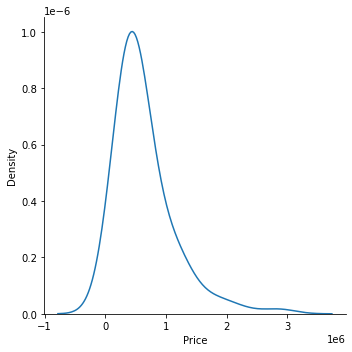

In [28]:
sns.displot(data, x="Price", kind="kde", bw_adjust=2)

In [29]:
# Delete prices of 0
data = data[data['Price'] > 1]

In [30]:
data

,Price,Surface,Ground,Bedrooms,Bathrooms,EPC,Parking,Balcony,neighbourhood
0,495000,145,436.0,2,2,NaN,Yes,Yes,Universiteitsbuurt
1,1200000,350,NaN,3,2,B,Yes,Yes,NaN
2,1200000,187,NaN,2,2,A,Yes,Yes,NaN
3,399000,67,67.0,1,1,A,Yes,Yes,Universiteitsbuurt
4,475000,100,NaN,2,1,C,Yes,Yes,Zuid
...,...,...,...,...,...,...,...,...,...
648,199500,51,NaN,1,1,NaN,No,No,Zuid
649,285000,80,NaN,2,1,C,No,No,Zuid
650,570000,109,NaN,2,1,A,No,No,Schipperskwartier
651,759000,169,NaN,3,2,NaN,No,No,NaN


In [31]:
one_hot_encoded_data = pd.get_dummies(data, columns = ['EPC', 'neighbourhood']) 
one_hot_encoded_data

,Price,Surface,Ground,Bedrooms,Bathrooms,Parking,Balcony,EPC_A,EPC_B,EPC_C,neighbourhood_Historisch centrum,neighbourhood_Schipperskwartier,neighbourhood_Sint Andries,neighbourhood_Theaterbuurt,neighbourhood_Universiteitsbuurt,neighbourhood_Zuid
0,495000,145,436.0,2,2,Yes,Yes,0,0,0,0,0,0,0,1,0
1,1200000,350,NaN,3,2,Yes,Yes,0,1,0,0,0,0,0,0,0
2,1200000,187,NaN,2,2,Yes,Yes,1,0,0,0,0,0,0,0,0
3,399000,67,67.0,1,1,Yes,Yes,1,0,0,0,0,0,0,1,0
4,475000,100,NaN,2,1,Yes,Yes,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,199500,51,NaN,1,1,No,No,0,0,0,0,0,0,0,0,1
649,285000,80,NaN,2,1,No,No,0,0,1,0,0,0,0,0,1
650,570000,109,NaN,2,1,No,No,1,0,0,0,1,0,0,0,0
651,759000,169,NaN,3,2,No,No,0,0,0,0,0,0,0,0,0


In [32]:
one_hot_encoded_data['Parking'] = one_hot_encoded_data['Parking'].map({'Yes': 1, 'No': 0})
one_hot_encoded_data['Balcony'] = one_hot_encoded_data['Balcony'].map({'Yes': 1, 'No': 0})
one_hot_encoded_data

,Price,Surface,Ground,Bedrooms,Bathrooms,Parking,Balcony,EPC_A,EPC_B,EPC_C,neighbourhood_Historisch centrum,neighbourhood_Schipperskwartier,neighbourhood_Sint Andries,neighbourhood_Theaterbuurt,neighbourhood_Universiteitsbuurt,neighbourhood_Zuid
0,495000,145,436.0,2,2,1,1,0,0,0,0,0,0,0,1,0
1,1200000,350,NaN,3,2,1,1,0,1,0,0,0,0,0,0,0
2,1200000,187,NaN,2,2,1,1,1,0,0,0,0,0,0,0,0
3,399000,67,67.0,1,1,1,1,1,0,0,0,0,0,0,1,0
4,475000,100,NaN,2,1,1,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,199500,51,NaN,1,1,0,0,0,0,0,0,0,0,0,0,1
649,285000,80,NaN,2,1,0,0,0,0,1,0,0,0,0,0,1
650,570000,109,NaN,2,1,0,0,1,0,0,0,1,0,0,0,0
651,759000,169,NaN,3,2,0,0,0,0,0,0,0,0,0,0,0


In [35]:
data_numeric = one_hot_encoded_data[['Price','Surface','Ground']]
data_binary = one_hot_encoded_data[['Parking','Balcony','EPC_A','EPC_B','EPC_C','neighbourhood_Historisch centrum',
                    'neighbourhood_Schipperskwartier','neighbourhood_Sint Andries','neighbourhood_Theaterbuurt'
                    ,'neighbourhood_Universiteitsbuurt','neighbourhood_Zuid']]

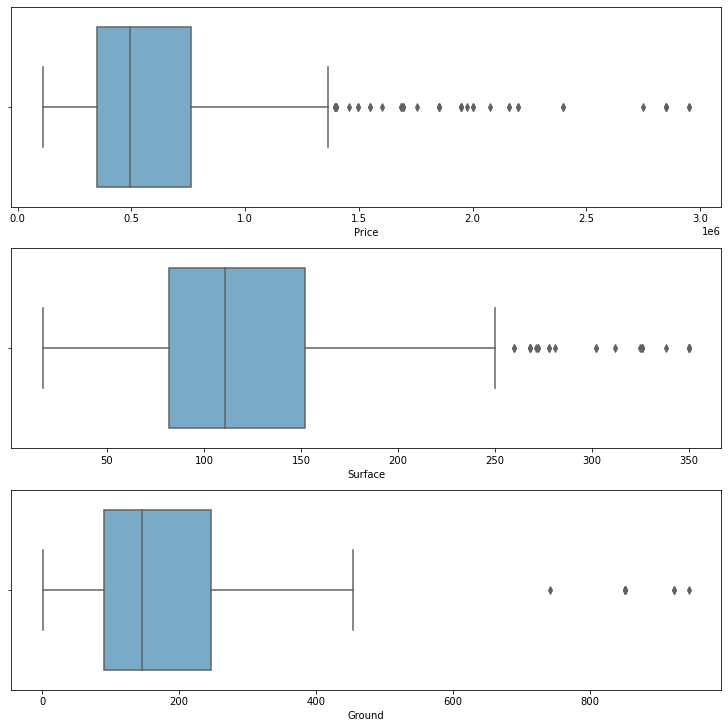

In [36]:
fig, axes = plt.subplots(len(data_numeric.columns), 1, figsize=(10,10), constrained_layout=True)


for i, col in enumerate(data_numeric):
    sns.boxplot(x=one_hot_encoded_data[col], palette='Blues_r', ax=axes[i])

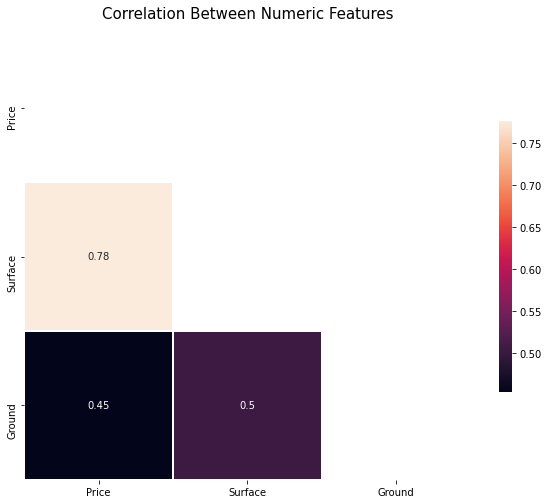

In [37]:
corr = data_numeric.corr()

fig, ax = plt.subplots(figsize=(10,10))

mask = np.triu(np.ones_like(corr, dtype=bool))

graph = sns.heatmap(corr, annot=True, mask = mask, 
                    square=True, linewidths=1, cbar_kws={"shrink": .5})

graph.set_title("Correlation Between Numeric Features", fontsize = 15, pad = 15)
plt.show()

In [39]:
data = one_hot_encoded_data

## Model

In [40]:
target = data.Price
df = data.drop('Price', axis=1)

X, y = df, target

# separate train and test data
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

In [42]:
def evaluate(model, target_train, target_test):
    target_train_pred = model.predict(X_train)
    target_test_pred = model.predict(X_test)
    r2_test = r2_score(target_test, target_test_pred)
    r2_train = r2_score(target_train, target_train_pred)
    mse_test = mean_squared_error(target_test, target_test_pred)

    print('Model Performance')
    print(f"R2 on test data: {r2_test}")
    print(f"R2 on training data: {r2_train}")
    print(f"RMSE on test data: {np.sqrt(mse_test)}")
    
    return target_test_pred

In [47]:
numerical_features = one_hot_encoded_data[['Surface','Ground']].columns
binary_features = one_hot_encoded_data[['Parking','Balcony','EPC_A','EPC_B','EPC_C','neighbourhood_Historisch centrum',
                    'neighbourhood_Schipperskwartier','neighbourhood_Sint Andries','neighbourhood_Theaterbuurt'
                    ,'neighbourhood_Universiteitsbuurt','neighbourhood_Zuid']].columns

In [48]:
# creating pipeline for numeric features
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

# creating a pipeline for binary features
bin_pipe = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy='constant'))
])

# creating the processor for each of our column transformer pipelines
preprocessor = ColumnTransformer([
    ("num", num_pipe, numerical_features),
    ("bin", bin_pipe, binary_features)
])

### Baseline Model

In [49]:
pipe_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("model", tree.DecisionTreeClassifier(random_state = 42))
])

In [50]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Surface', 'Ground'], dtype='object')),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  Index(['Parking', 'Balcony', 'EPC_A', 'EPC_B', 'EPC_C',
       'neighbourhood_Historisch centrum', 'neighbourhood_Schipperskwartier',
       'neighbourhood_Sint Andries', 'neighbourhood_Theaterbuurt',
       'neighbourhood_Universiteitsbuurt', 'neighbourhood_Zuid'],
      dtype='object'))])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [51]:
evaluate(pipe_dt, y_train, y_test)

Model Performance
R2 on test data: 0.603947390913463
R2 on training data: 0.9697030198755664
RMSE on test data: 297610.36631171603


array([ 163000,  399000,  598000,  579000,  575000,  955000,  529000,
        335000,  585000, 2750000, 1106500,  189500,  174000,  435000,
        569500,  549000,  549500,  319000,  485000,  598000,  569500,
        597000, 1200000,  570000, 2395000,  349000, 1395000,  800000,
        549000,  529000, 2850000,  489000,  298500,  349000, 1400000,
        185000,  569500,  465000,  495000, 1695000,  485000,  325000,
        695000,  580000,  498000, 1200000,  259000,  720000,  955000,
       1455000,  439900,  495000,  245000, 1695000,  598000, 1150000,
        450000,  435000,  145000,  415000,  269000,  995000,  745000,
        435000,  289000,  465000,  999000, 1200000,  355000,  335000,
        485000,  299000,  349000,  210000,  480000,  495000,  695000,
        570000, 1150000,  549000,  650000,  248000,  699000,  386000,
        599000,  435000,  299500,  620000,  489000,  795000,  696600,
        415000,  999000,  285000,  510000,  399000,  480000,  179000,
        349000,  699

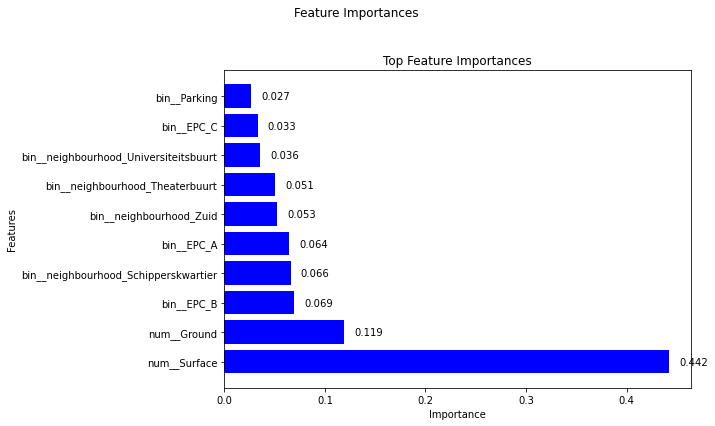

In [52]:
importances = pipe_dt.named_steps['model'].feature_importances_

feature_names = pipe_dt.named_steps['preprocessor'].get_feature_names_out()

feature_importance_dict = dict(zip(feature_names, importances))

sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_features = [item[0] for item in sorted_feature_importances]
sorted_importances = [item[1] for item in sorted_feature_importances]

top_n = 10
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_importances, color='blue')

for i, (feature, importance) in enumerate(zip(top_features, top_importances)):
    plt.text(importance + 0.01, i, f'{importance:.3f}', va='center')

plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top Feature Importances')

plt.suptitle('Feature Importances')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Linear Regression

In [53]:
# Creating the new pipeline

# create pipeline
pipe_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# fit pipeline
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Surface', 'Ground'], dtype='object')),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  Index(['Parking', 'Balcony', 'EPC_A', 'EPC_B', 'EPC_C',
       'neighbourhood_Historisch centrum', 'neighbourhood_Schipperskwartier',
       'neighbourhood_Sint Andries', 'neighbourhood_Theaterbuurt',
       'neighbourhood_Universiteitsbuurt', 'neighbourhood_Zuid'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [54]:
evaluate(pipe_lr, y_train, y_test)

Model Performance
R2 on test data: 0.664670730654017
R2 on training data: 0.6439288103055874
RMSE on test data: 273846.5957001879


array([  67116.82009559,  357751.14855393,  584880.33404822,
        495803.0796542 , 1007590.25142996,  995960.44722544,
        564386.1699912 ,  398045.26508227,  724422.87834297,
       1523556.13686145, 1124359.83652952,  -18872.20770125,
         34060.5685138 ,  488246.13956486,  691385.10702732,
        326977.81089897,  447164.11037515,  389025.99025887,
        613193.37951227,  584880.33404822,  628413.88705892,
        821992.73484002,  915471.86501386,  537093.19722946,
       1530295.1366435 ,  287673.97586457, 1080265.39264741,
        875227.57390807,  599755.34983397,  619038.52668929,
       1627041.45684777,  576002.44712492,  214093.04191367,
        514430.52639568,  971120.22923128,  135048.28536717,
        691385.10702732,  504513.14207621,  342018.92533981,
       1614334.24802383,  592191.63613823,  417817.07116033,
        748876.95146417,  649223.30398802,  599266.72061122,
       1187193.74242283,  114848.81170564, 1080827.15516835,
        917996.11776087,

### Random Forest

In [55]:
# create pipeline
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=7, n_jobs=-1))
])
start = time.time()

# fit pipeline
pipe_rf.fit(X_train, y_train)

stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 0.5626533031463623s


In [56]:
target_test_pred = evaluate(pipe_rf, y_train, y_test)

Model Performance
R2 on test data: 0.6933159214935493
R2 on training data: 0.9468507425483086
RMSE on test data: 261888.9836168067


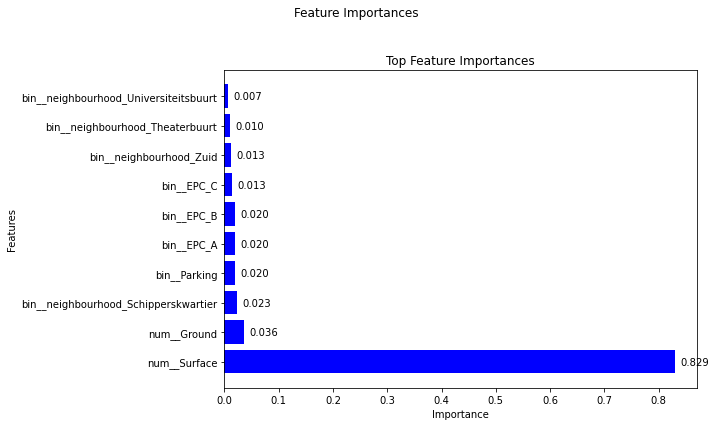

In [57]:
importances = pipe_rf.named_steps['model'].feature_importances_

feature_names = pipe_rf.named_steps['preprocessor'].get_feature_names_out()

feature_importance_dict = dict(zip(feature_names, importances))

sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_features = [item[0] for item in sorted_feature_importances]
sorted_importances = [item[1] for item in sorted_feature_importances]

top_n = 10
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_importances, color='blue')

for i, (feature, importance) in enumerate(zip(top_features, top_importances)):
    plt.text(importance + 0.01, i, f'{importance:.3f}', va='center')

plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top Feature Importances')

plt.suptitle('Feature Importances')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Other Pipeline

In [63]:
df

,Surface,Ground,Bedrooms,Bathrooms,Parking,Balcony,EPC_A,EPC_B,EPC_C,neighbourhood_Historisch centrum,neighbourhood_Schipperskwartier,neighbourhood_Sint Andries,neighbourhood_Theaterbuurt,neighbourhood_Universiteitsbuurt,neighbourhood_Zuid
0,145,436.0,2,2,1,1,0,0,0,0,0,0,0,1,0
1,350,NaN,3,2,1,1,0,1,0,0,0,0,0,0,0
2,187,NaN,2,2,1,1,1,0,0,0,0,0,0,0,0
3,67,67.0,1,1,1,1,1,0,0,0,0,0,0,1,0
4,100,NaN,2,1,1,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,51,NaN,1,1,0,0,0,0,0,0,0,0,0,0,1
649,80,NaN,2,1,0,0,0,0,1,0,0,0,0,0,1
650,109,NaN,2,1,0,0,1,0,0,0,1,0,0,0,0
651,169,NaN,3,2,0,0,0,0,0,0,0,0,0,0,0
